In [1]:
import os
import nest_asyncio
nest_asyncio.apply()
from dotenv import load_dotenv
load_dotenv("D:\\Code\\AI\\.env")
from agents import AsyncOpenAI, OpenAIChatCompletionsModel

ollama_client = AsyncOpenAI( api_key="fake_key", base_url="http://localhost:11434/v1",)
qwen_25=OpenAIChatCompletionsModel( model="qwen2.5:14b",openai_client=ollama_client)

deepseek_client = AsyncOpenAI( api_key=os.getenv("DEEPSEEK_API_KEY"), base_url="https://api.deepseek.com/",)
deepseek=OpenAIChatCompletionsModel( model="deepseek-chat", openai_client=deepseek_client, )


from agents.run import RunConfig
run_config = RunConfig(tracing_disabled=True)


import textwrap
from IPython.display import Markdown

def to_markdown(text):
    # text = text.replace('*',' *')
    return Markdown(textwrap.indent(text,'> ',predicate=lambda _:True))

### Model

We can run OpenAI Agent SDK with other model as well. Below are few examples

In [ ]:
#-------------------------------------------------------
# Ollama  (Make sure the model use supports Tools Calling)
#-------------------------------------------------------


from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
import os

ollama_client = AsyncOpenAI(
    api_key="fake_key",
    base_url="http://localhost:11434/v1",
)

spanish_agent = Agent(
    name="User agent",
    instructions="You are helpful assistant",
    model=OpenAIChatCompletionsModel(
        model="qwen2.5:14b",
        openai_client=ollama_client,
    ),
    # model_settings=ModelSettings(temperature=0.5),
)

def main():
    result =  Runner.run_sync(spanish_agent, "What is the capital of India?")
    print(result.final_output)
main()




In [ ]:
#-------------------------------------------------------
# Deepseek  (Make sure the model use supports Tools Calling)
#-------------------------------------------------------


from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
import os

deepseek_client = AsyncOpenAI(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com/",
)

spanish_agent = Agent(
    name="Telugu agent",
    instructions="You only speak Telugu. Give the answer in Telugu",
    model=OpenAIChatCompletionsModel(
        model="deepseek-chat",
        openai_client=deepseek_client,
    ),
    # model_settings=ModelSettings(temperature=0.5),
)

def main():
    result =  Runner.run_sync(spanish_agent, "What is the capital of India?")
    print(result.final_output)
main()



# 6 Building blocks, workflows, and agents(OpenAI SDK)

### 6.1 Building block: The augmented LLM

<style>
  img {
    width: 700px;
  }
</style>
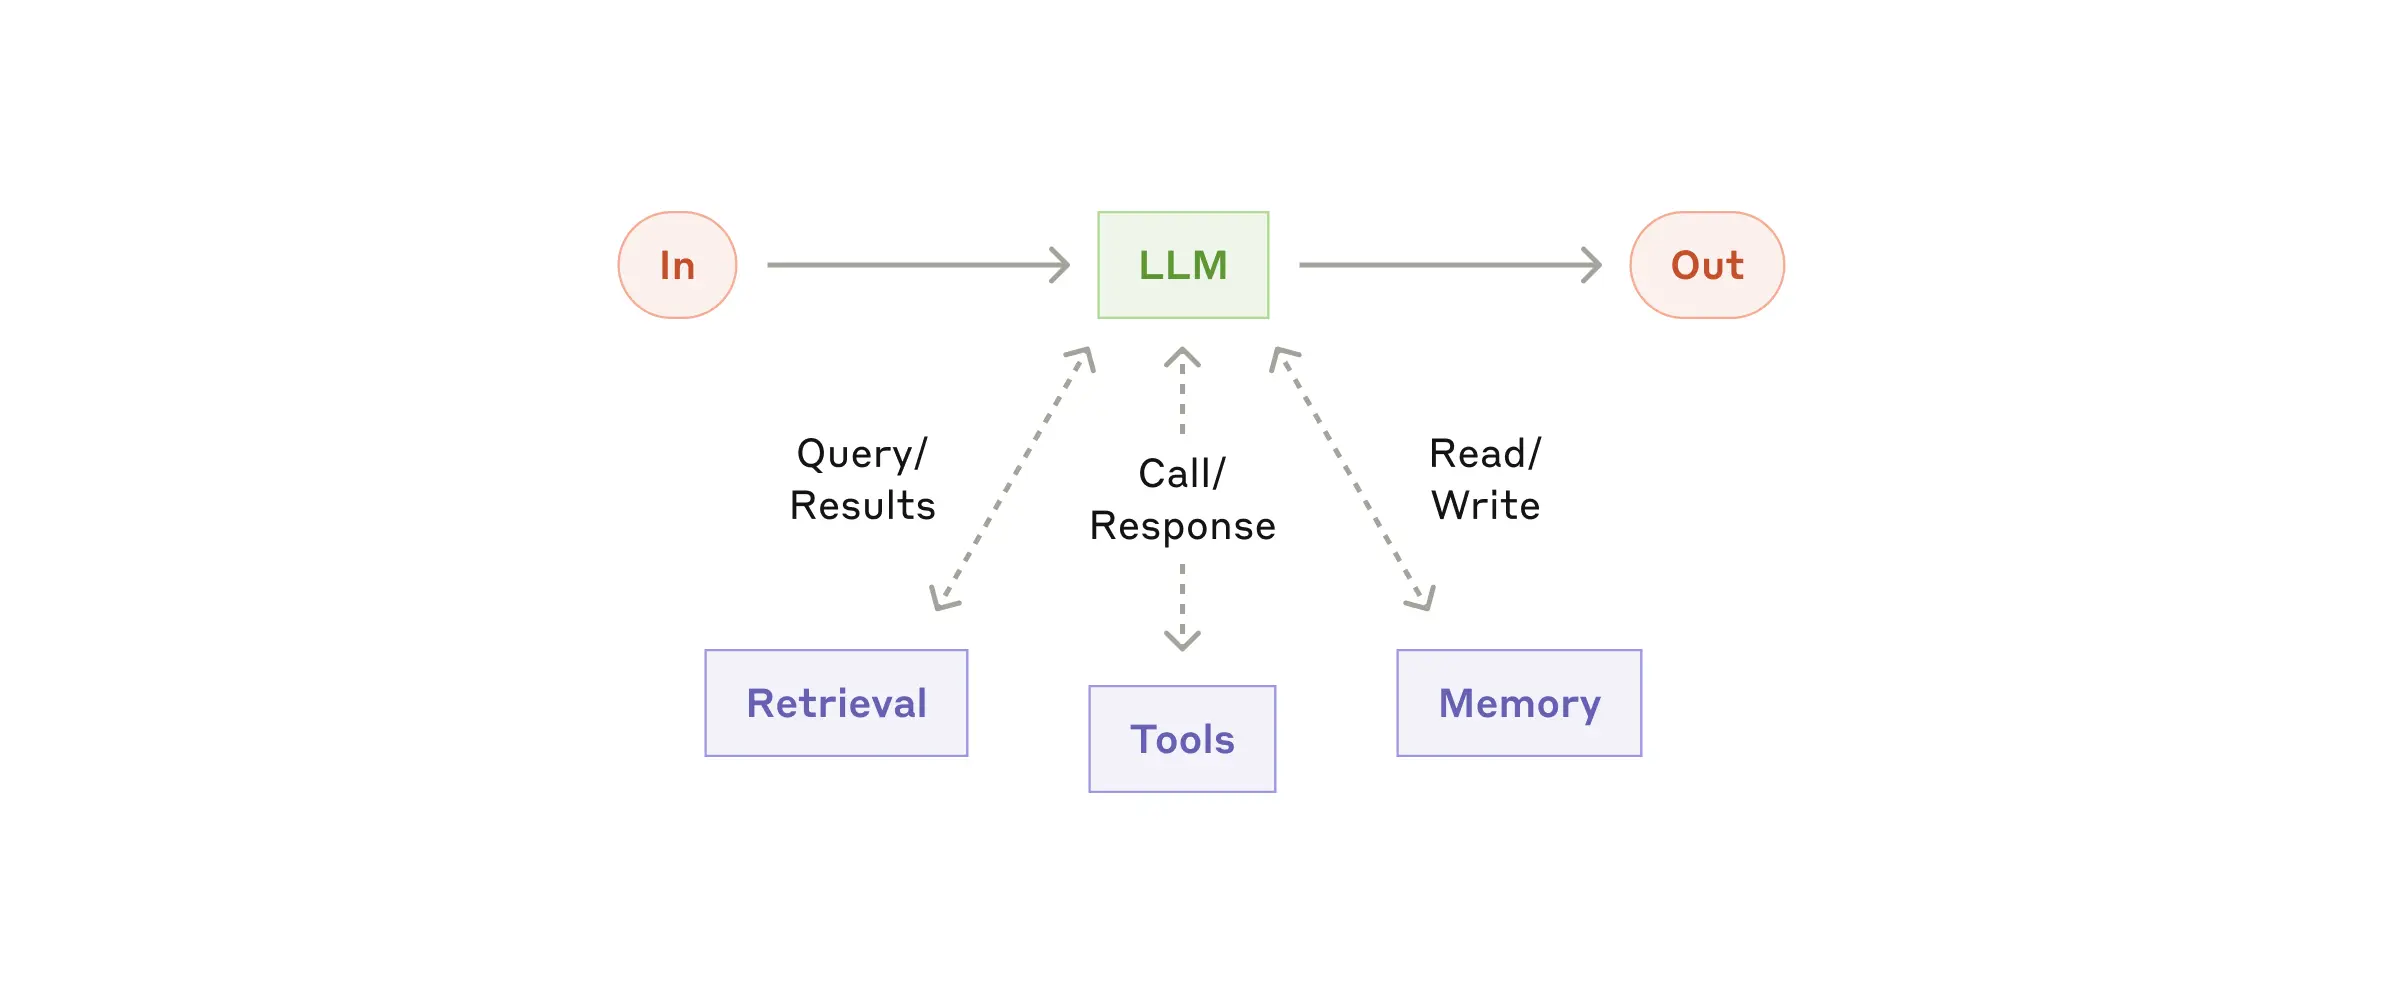

Credits- https://www.anthropic.com/engineering/building-effective-agents

<style>
  img {
    width: 700px;
  }
</style>
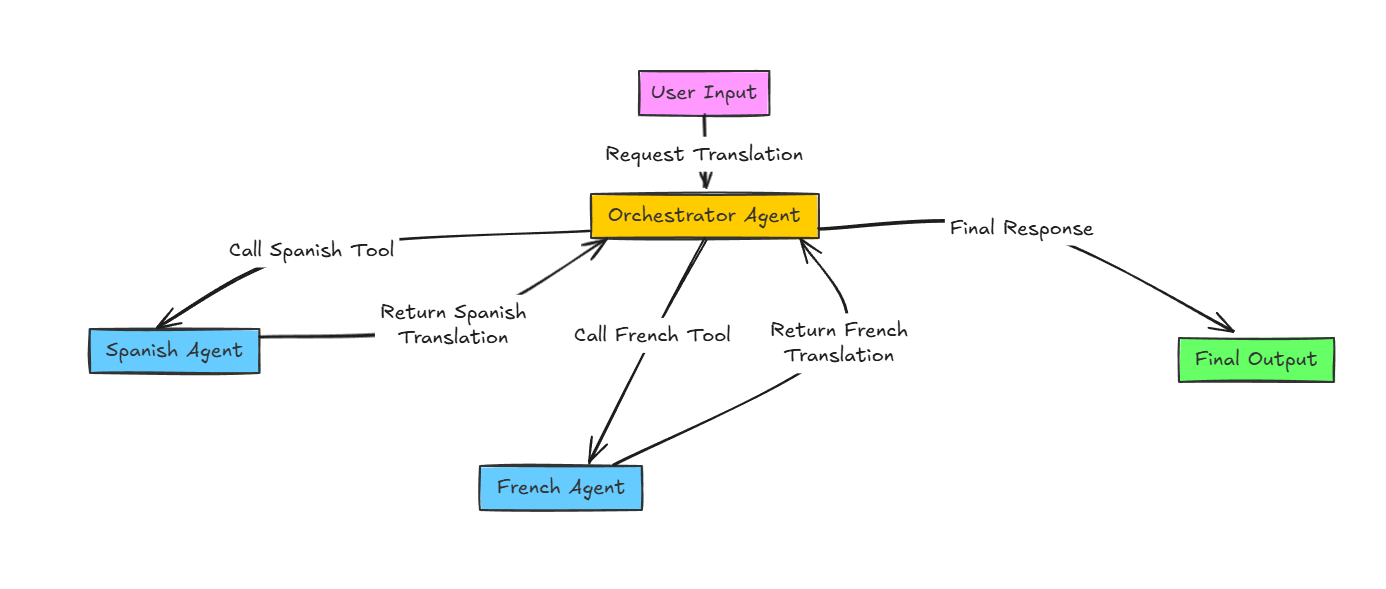

In [ ]:
from agents import Agent, Runner
import asyncio
from agents import  FunctionTool, function_tool, RunContextWrapper, AsyncOpenAI, OpenAIChatCompletionsModel

import os

deepseek_client = AsyncOpenAI(api_key=os.getenv("DEEPSEEK_API_KEY"), base_url="https://api.deepseek.com/",)
ollama_client = AsyncOpenAI( api_key="fake_key", base_url="http://localhost:11434/v1",)


spanish_agent = Agent(model=OpenAIChatCompletionsModel( model="deepseek-chat", openai_client=deepseek_client, ),
    name="Spanish agent",
    instructions="You translate the user's message to Spanish",
)

french_agent = Agent(model=OpenAIChatCompletionsModel( model="qwen2.5:14b",openai_client=ollama_client,),
    name="French agent",
    instructions="You translate the user's message to French",
)

orchestrator_agent = Agent(
    name="orchestrator_agent",
    instructions=(
        "You are a translation agent. You use the tools given to you to translate."
        "If asked for multiple translations, you call the relevant tools."
    ),
    tools=[
        spanish_agent.as_tool(
            tool_name="translate_to_spanish",
            tool_description="Translate the user's message to Spanish",
        ),
        french_agent.as_tool(
            tool_name="translate_to_french",
            tool_description="Translate the user's message to French",
        ),
    ],
)

async def main():
    result = await Runner.run(orchestrator_agent, input="Say 'Hello, how are you?' in Spanish.")
    print(result.final_output)
    result = await Runner.run(orchestrator_agent, input="Say 'Hello, how are you?' in French.")
    print(result.final_output)

asyncio.run(main=main())

### 6.2 Workflow: Prompt chaining

<style>
  img {
    width: 700px;
  }
</style>
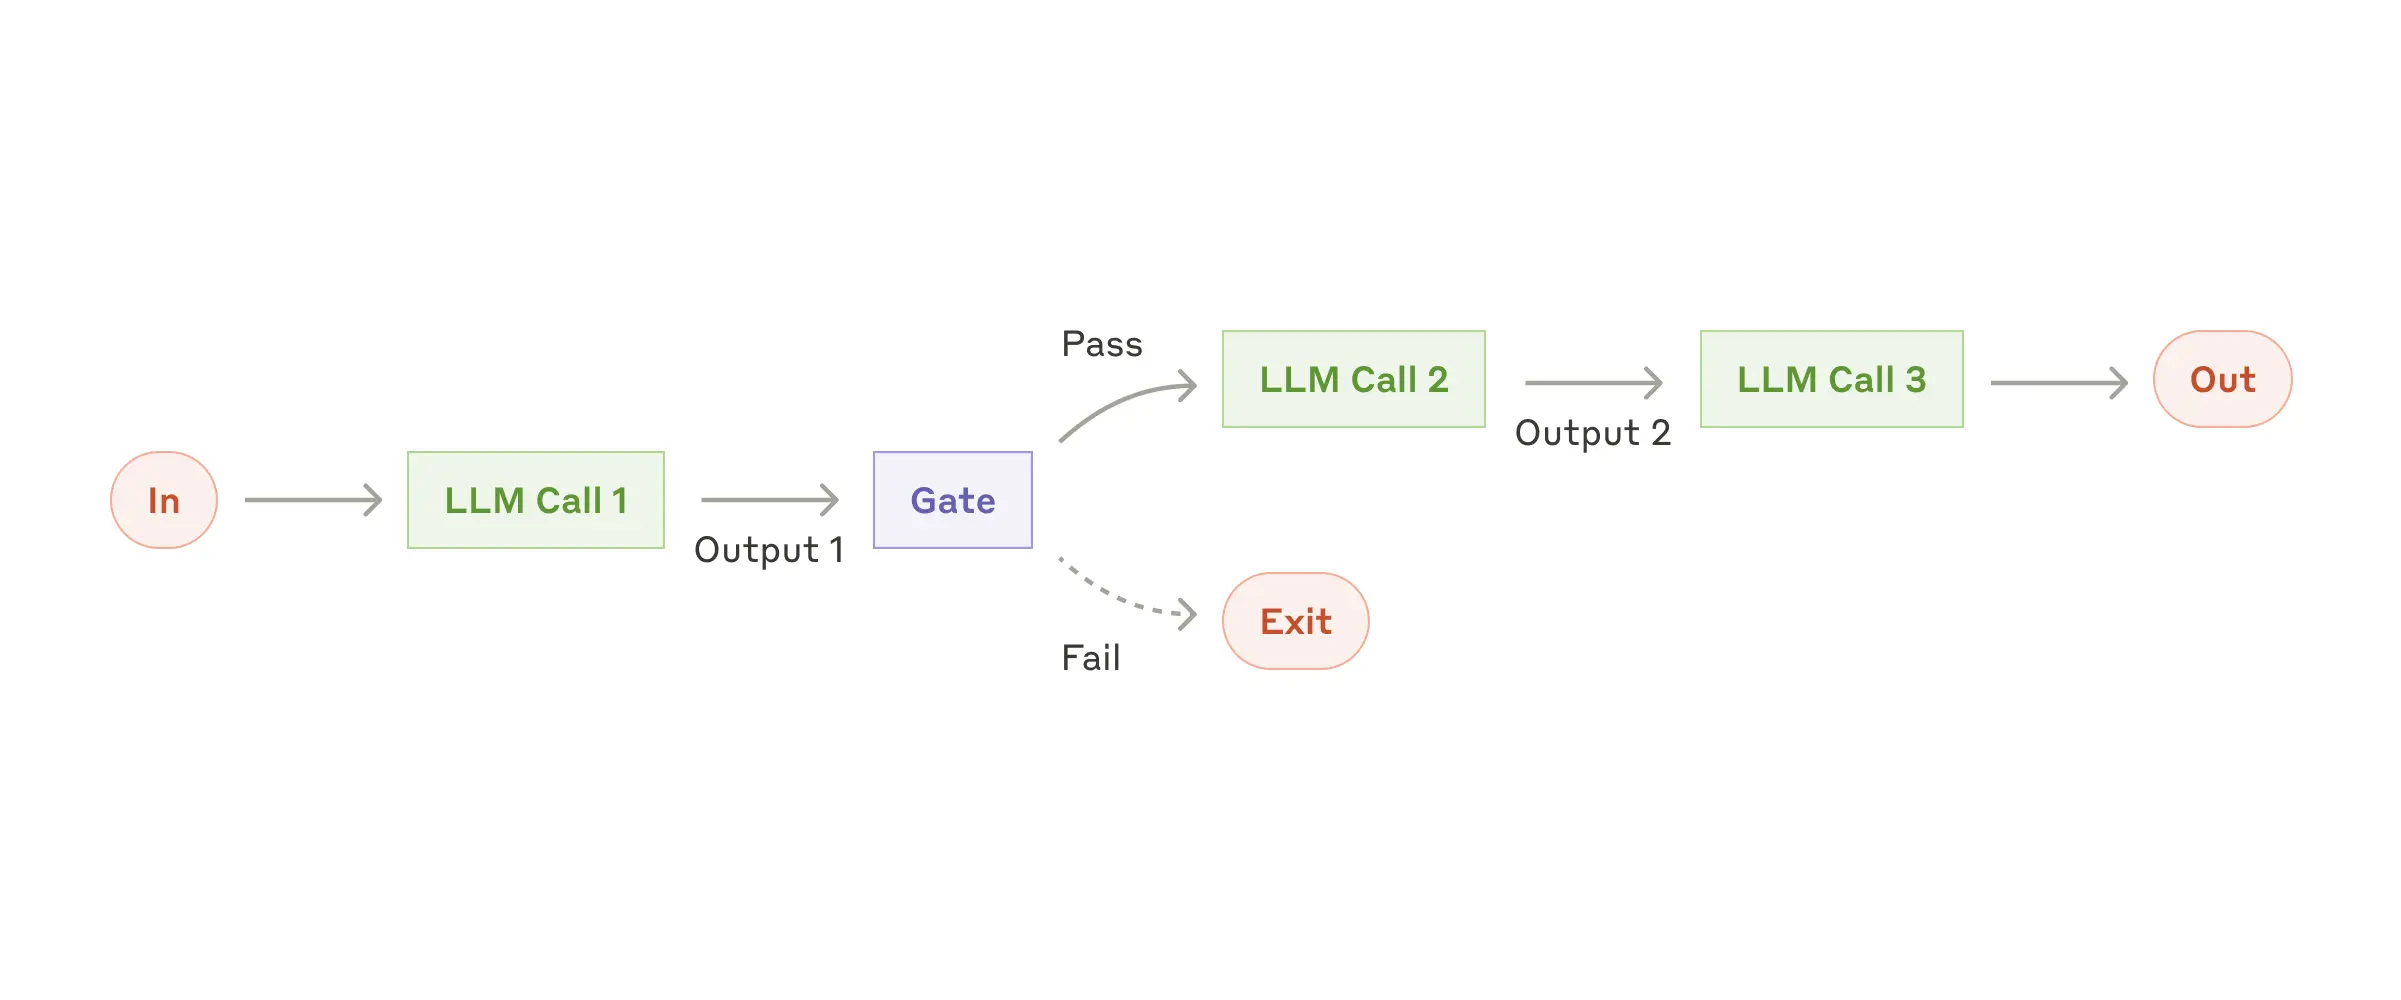

<style>
  img {
    width: 1400px;
  }
</style>
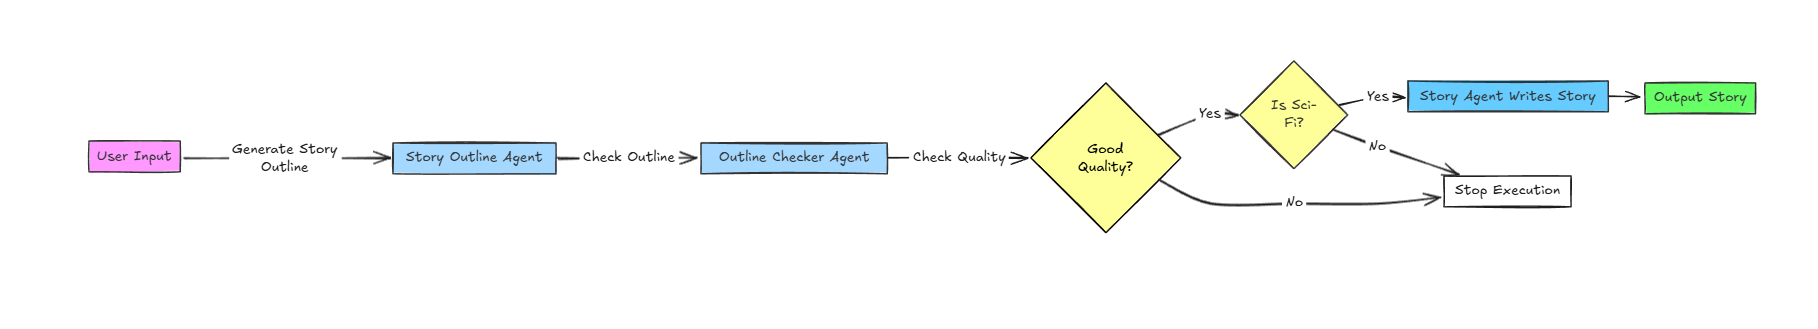

In [ ]:
#-----------------------------------------------
# Deterministic Flow
# This example demonstrates a deterministic flow, where each step is performed by an agent.
# 1. The first agent generates a story outline
# 2. We feed the outline into the second agent
# 3. The second agent checks if the outline is good quality and if it is a scifi story
# 4. If the outline is not good quality or not a scifi story, we stop here
# 5. If the outline is good quality and a scifi story, we feed the outline into the third agent
# 6. The third agent writes the story
#-----------------------------------------------



import asyncio
from agents import Agent, Runner, trace
from pydantic import BaseModel


story_outline_agent = Agent(model=qwen_25,
    name="story_outline_agent",
    instructions="Generate a very short story outline based on the user's input.",
)



class OutlineCheckerOutput(BaseModel):
    good_quality: bool
    is_scifi: bool

outline_checker_agent = Agent(model=qwen_25,
    name="outline_checker_agent",
    instructions="Read the given story outline, and judge the quality. Also, determine if it is a scifi story.",
    output_type=OutlineCheckerOutput,
)


story_agent = Agent(model=qwen_25,
    name="story_agent",
    instructions="Write a short story based on the given outline.",
    output_type=str,
)

async def main():
    input_prompt = input("What kind of story do you want? ")
    print("Input \n",input_prompt)
    # Ensure the entire workflow is a single trace
    with trace("Deterministic story flow"):
        # 1. Generate an outline
        outline_result = await Runner.run(
            story_outline_agent,
            input_prompt,
        )
        print("Outline generated")

        # 2. Check the outline
        outline_checker_result = await Runner.run(
            outline_checker_agent,
            outline_result.final_output,
        )

        # 3. Add a gate to stop if the outline is not good quality or not a scifi story
        assert isinstance(outline_checker_result.final_output, OutlineCheckerOutput)
        if not outline_checker_result.final_output.good_quality:
            print("Outline is not good quality, so we stop here.")
            exit(0)

        if not outline_checker_result.final_output.is_scifi:
            print("Outline is not a scifi story, so we stop here.")
            exit(0)

        print("Outline is good quality and a scifi story, so we continue to write the story.")


        # 4. Write the story
        story_result = await Runner.run(
            story_agent,
            outline_result.final_output,
        )
        print(f"Story: {story_result.final_output}")


if __name__ == "__main__":
    asyncio.run(main())

### 6.3 Workflow: Routing

<style>
  img {
    width: 700px;
  }
</style>
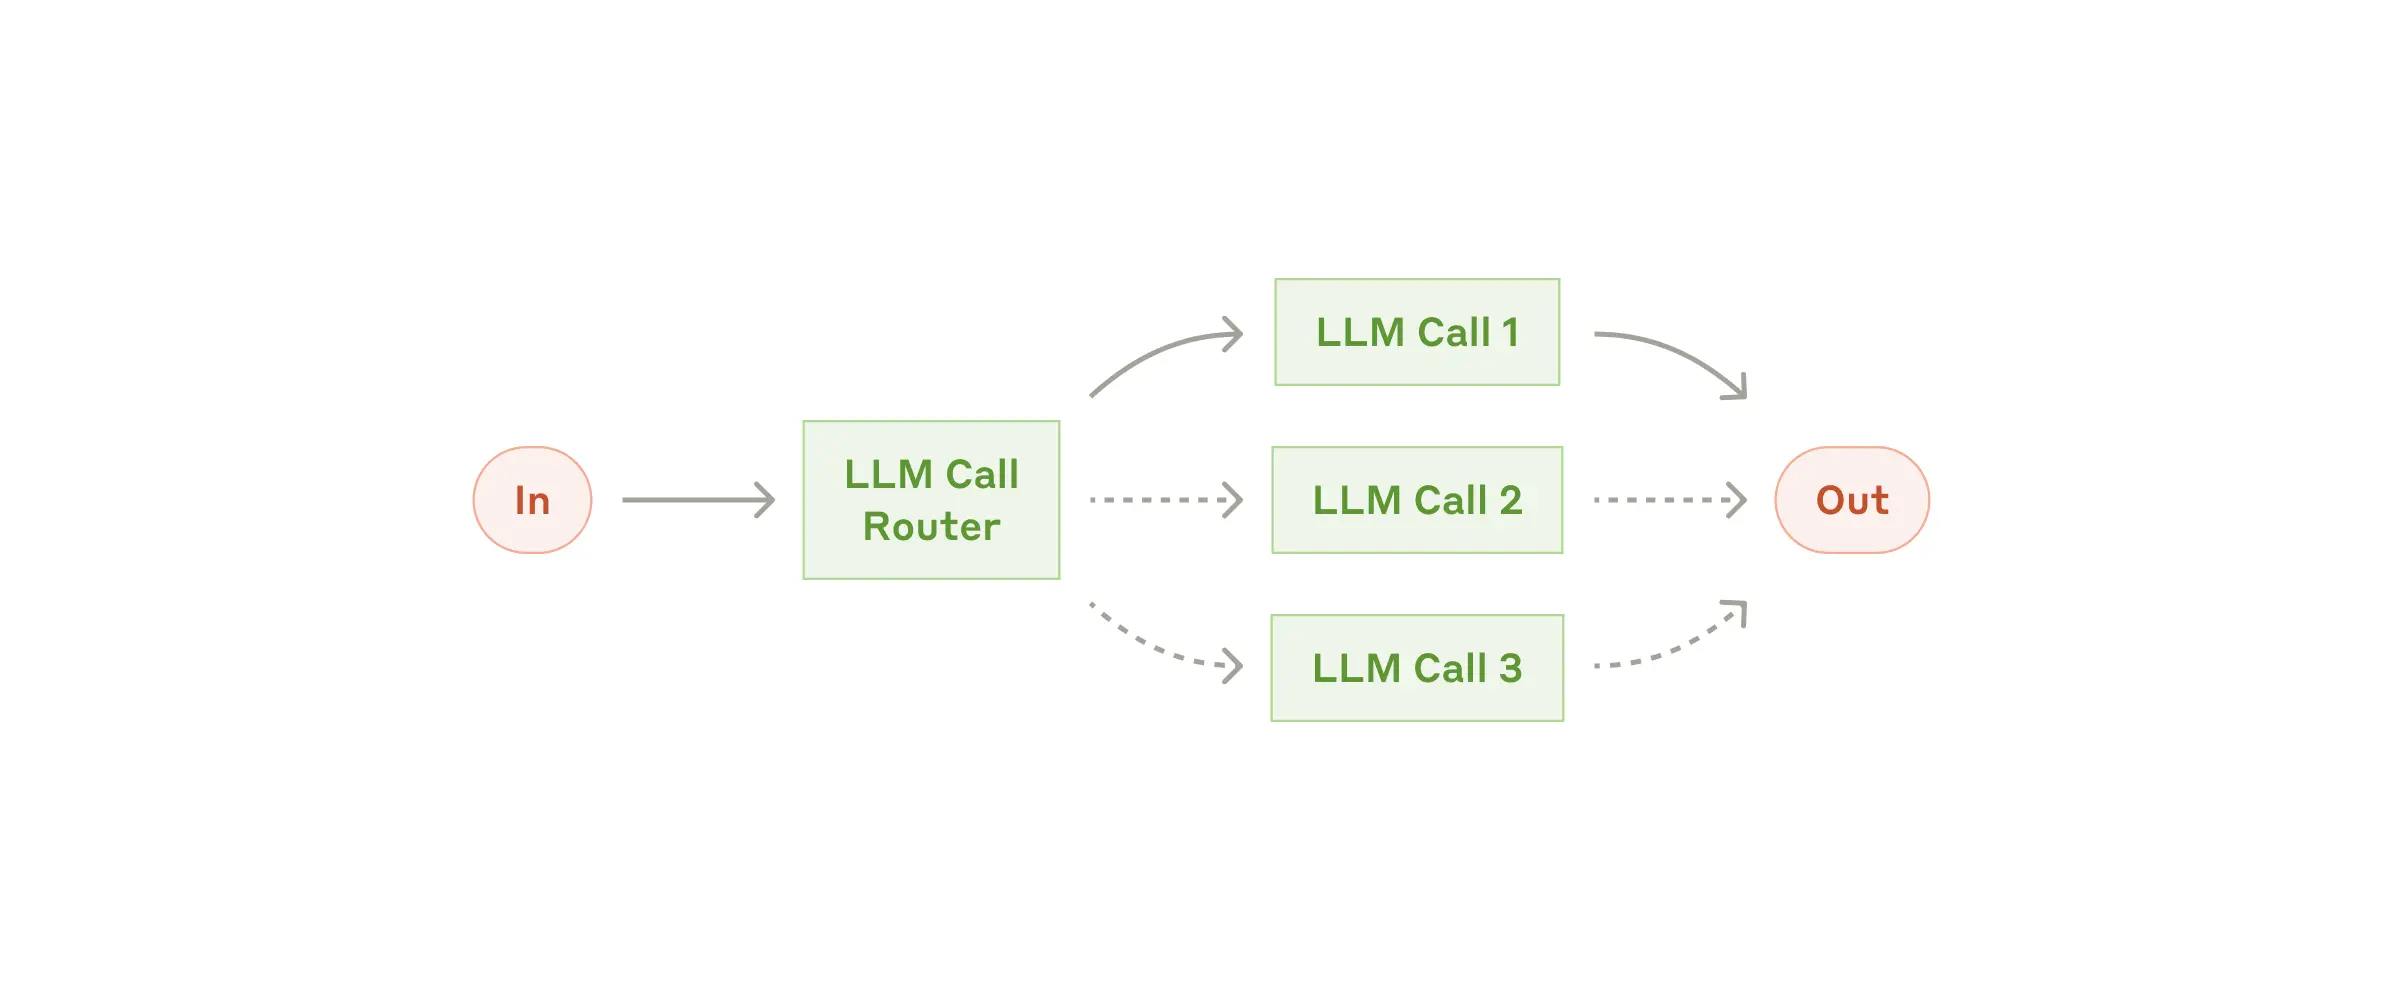

<style>
  img {
    width: 700px;
  }
</style>

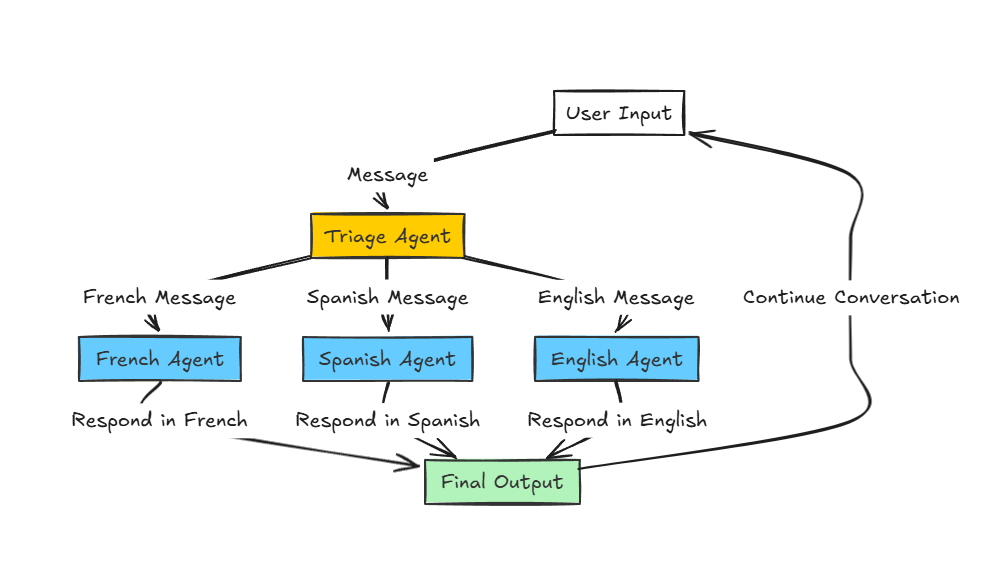

In [ ]:
import asyncio
import uuid

from openai.types.responses import ResponseContentPartDoneEvent, ResponseTextDeltaEvent

from agents import Agent, RawResponsesStreamEvent, Runner, TResponseInputItem, trace

"""
This example shows the handoffs/routing pattern. The triage agent receives the first message, and
then hands off to the appropriate agent based on the language of the request. Responses are
streamed to the user.
"""

french_agent = Agent(
    name="french_agent",
    instructions="You only speak French",
)

spanish_agent = Agent(
    name="spanish_agent",
    instructions="You only speak Spanish",
)

english_agent = Agent(
    name="english_agent",
    instructions="You only speak English",
)

triage_agent = Agent(
    name="triage_agent",
    instructions="Handoff to the appropriate agent based on the language of the request.",
    handoffs=[french_agent, spanish_agent, english_agent],
)


async def main():
    # We'll create an ID for this conversation, so we can link each trace
    conversation_id = str(uuid.uuid4().hex[:16])

    msg = input("Hi! We speak French, Spanish and English. How can I help? ")
    agent = triage_agent
    inputs: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    while True:
        # Each conversation turn is a single trace. Normally, each input from the user would be an
        # API request to your app, and you can wrap the request in a trace()
        with trace("Routing example", group_id=conversation_id):
            result = Runner.run_streamed(
                agent,
                input=inputs,
            )
            async for event in result.stream_events():
                if not isinstance(event, RawResponsesStreamEvent):
                    continue
                data = event.data
                if isinstance(data, ResponseTextDeltaEvent):
                    print(data.delta, end="", flush=True)
                elif isinstance(data, ResponseContentPartDoneEvent):
                    print("\n")

        inputs = result.to_input_list()
        print("\n")

        user_msg = input("Enter a message: ")
        inputs.append({"content": user_msg, "role": "user"})
        agent = result.current_agent


if __name__ == "__main__":
    asyncio.run(main())

### 6.4 Workflow: Parallelization
<style>
  img {
    width: 700px;
  }
</style>
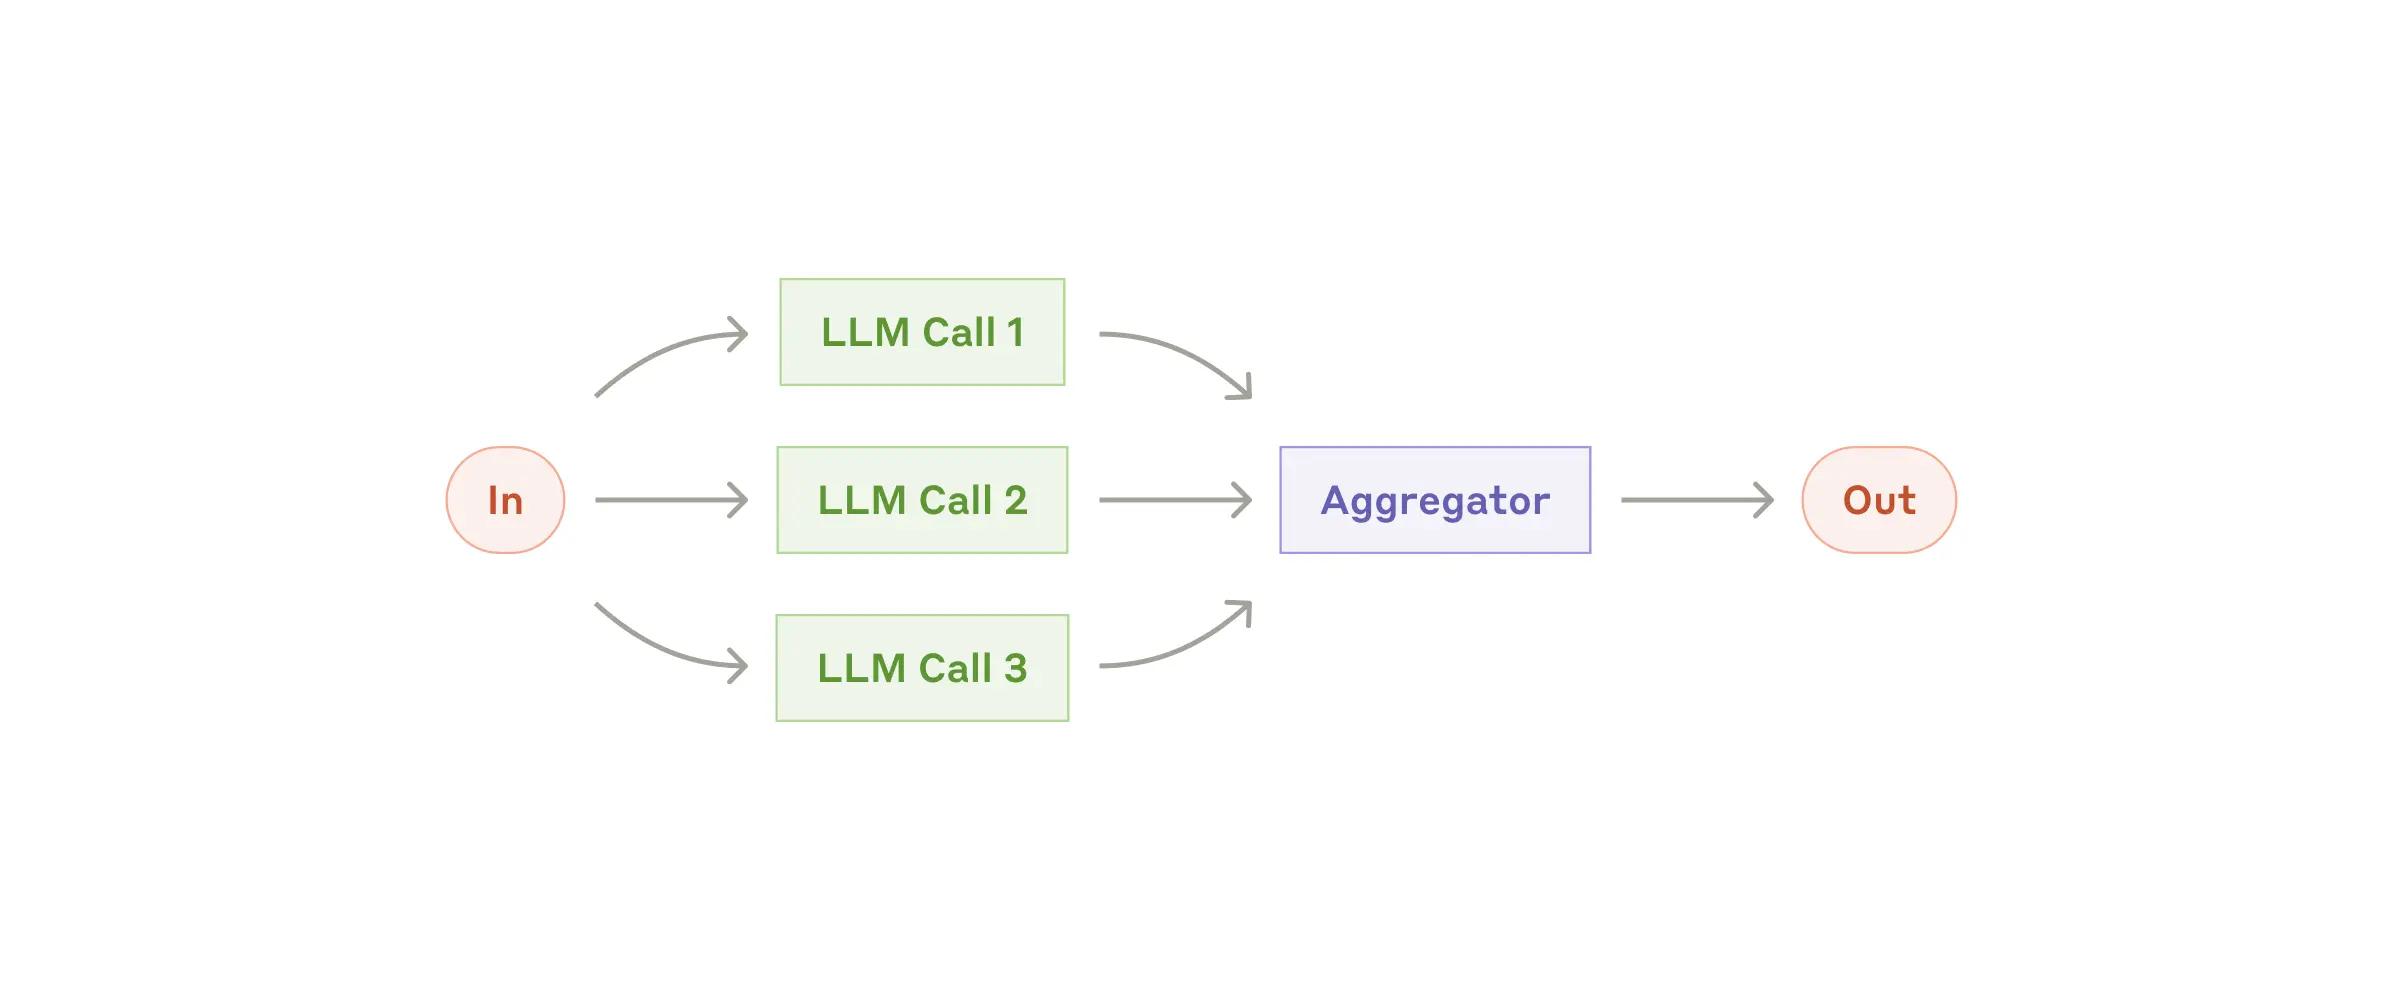


<style>
  img {
    width: 700px;
  }
</style>
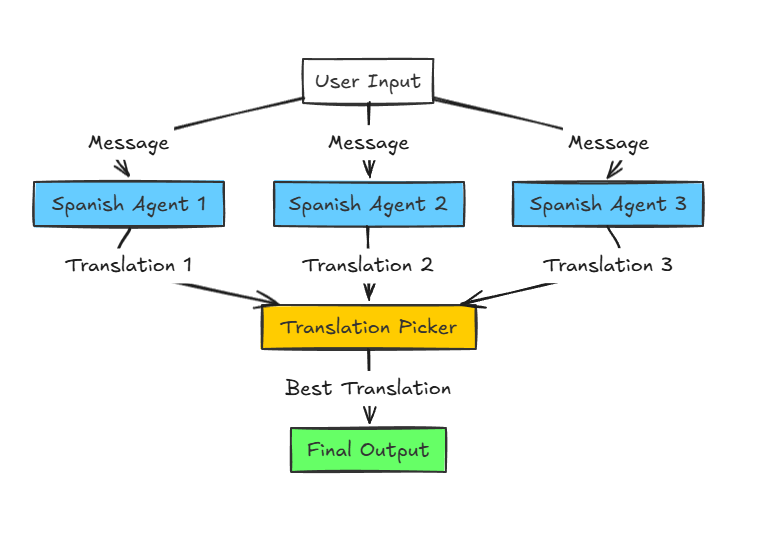

In [ ]:
import asyncio

from agents import Agent, ItemHelpers, Runner, trace

"""
This example shows the parallelization pattern. We run the agent three times in parallel, and pick
the best result.
"""

spanish_agent = Agent(
    name="spanish_agent",
    instructions="You translate the user's message to Spanish",
)

translation_picker = Agent(
    name="translation_picker",
    instructions="You pick the best Spanish translation from the given options.",
)


async def main():
    msg = input("Hi! Enter a message, and we'll translate it to Spanish.\n\n")

    # Ensure the entire workflow is a single trace
    with trace("Parallel translation"):
        res_1, res_2, res_3 = await asyncio.gather(
            Runner.run(
                spanish_agent,
                msg,
            ),
            Runner.run(
                spanish_agent,
                msg,
            ),
            Runner.run(
                spanish_agent,
                msg,
            ),
        )

        outputs = [
            ItemHelpers.text_message_outputs(res_1.new_items),
            ItemHelpers.text_message_outputs(res_2.new_items),
            ItemHelpers.text_message_outputs(res_3.new_items),
        ]

        translations = "\n\n".join(outputs)
        print(f"\n\nTranslations:\n\n{translations}")

        best_translation = await Runner.run(
            translation_picker,
            f"Input: {msg}\n\nTranslations:\n{translations}",
        )

    print("\n\n-----")

    print(f"Best translation: {best_translation.final_output}")


if __name__ == "__main__":
    asyncio.run(main())

### 6.5 Workflow: Orchestrator-workers

<style>
  img {
    width: 700px;
  }
</style>
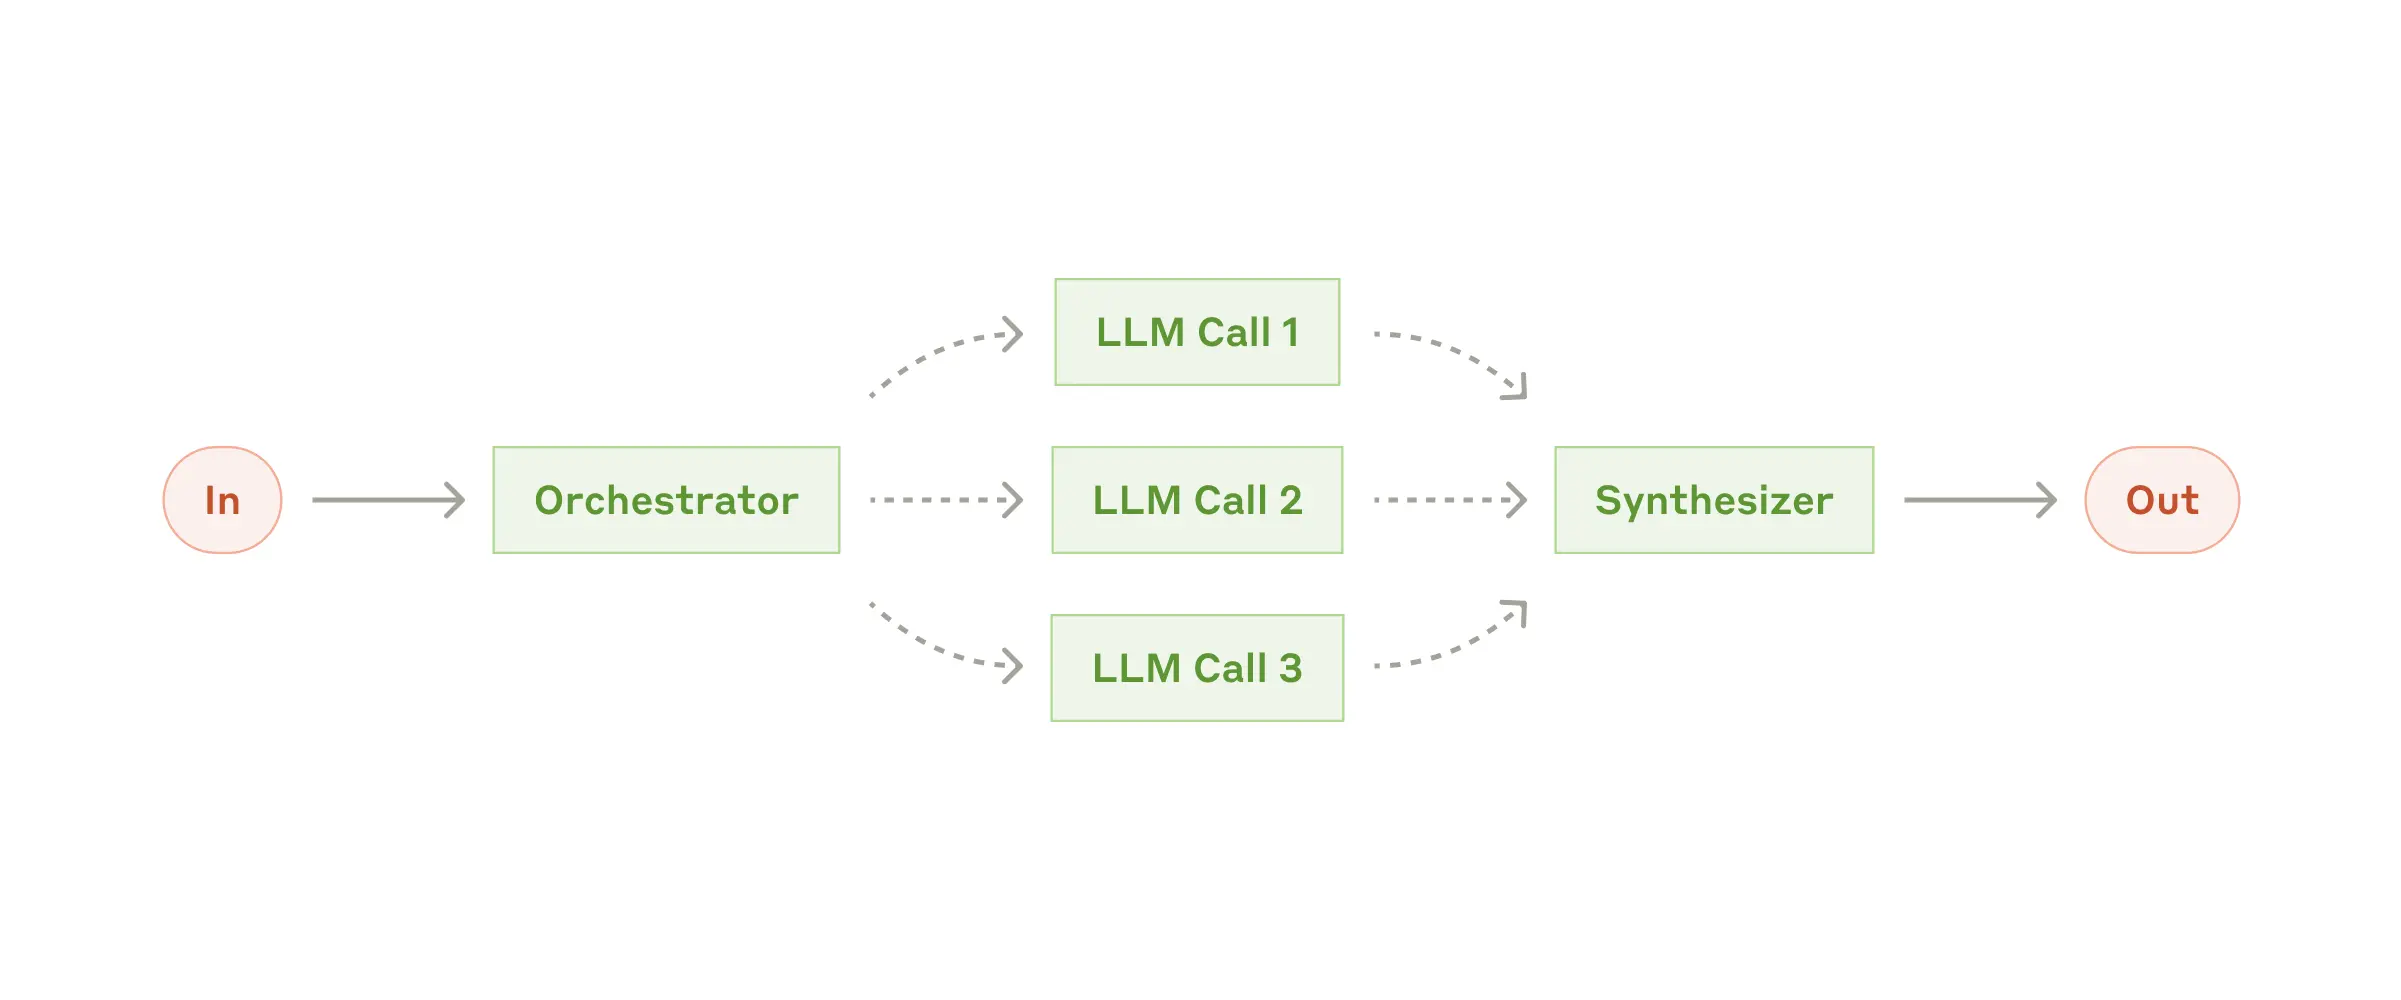


### 6.6 Workflow: Evaluator-optimizer

<style>
  img {
    width: 700px;
  }
</style>
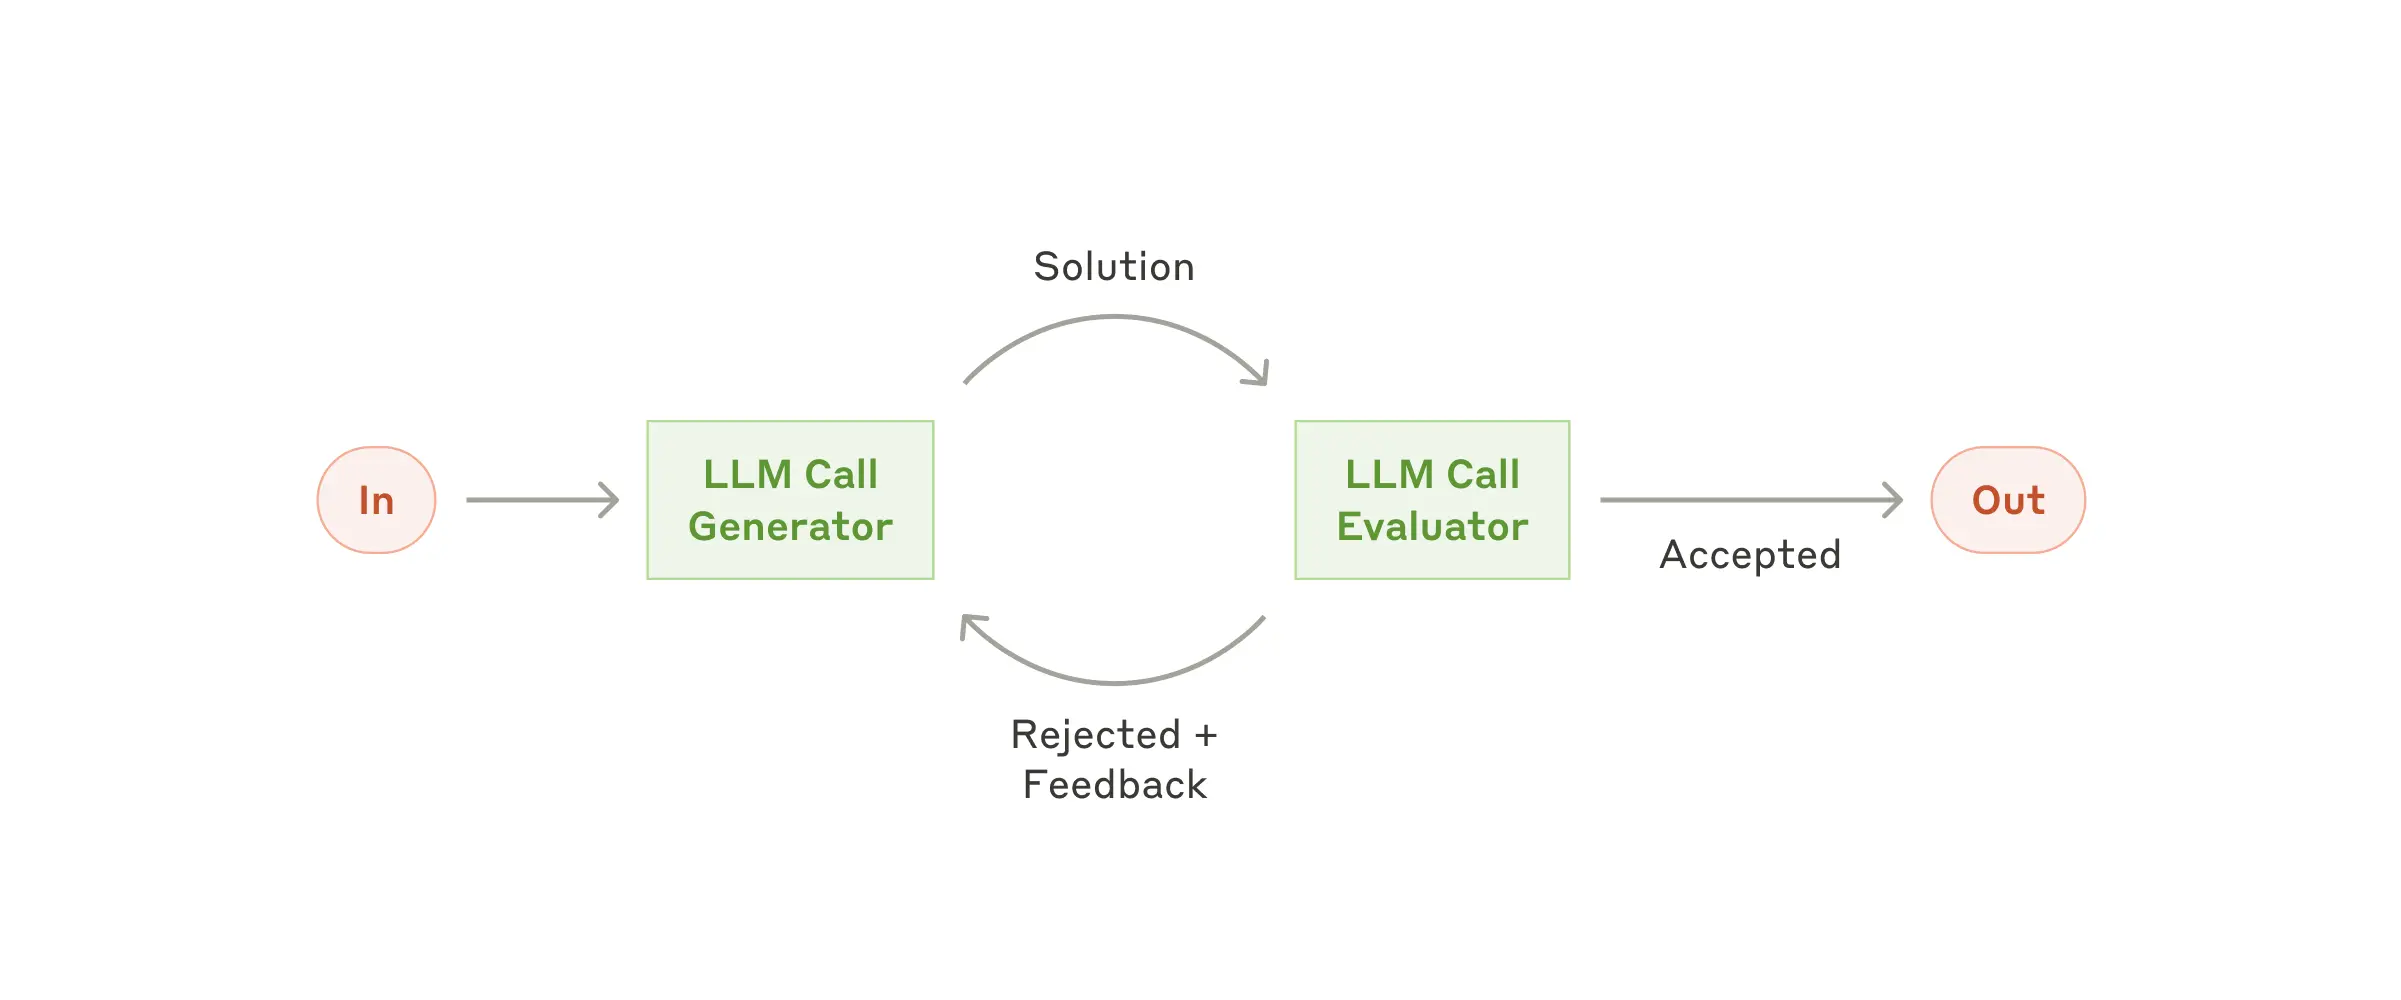


<style>
  img {
    width: 1200px;
  }
</style>
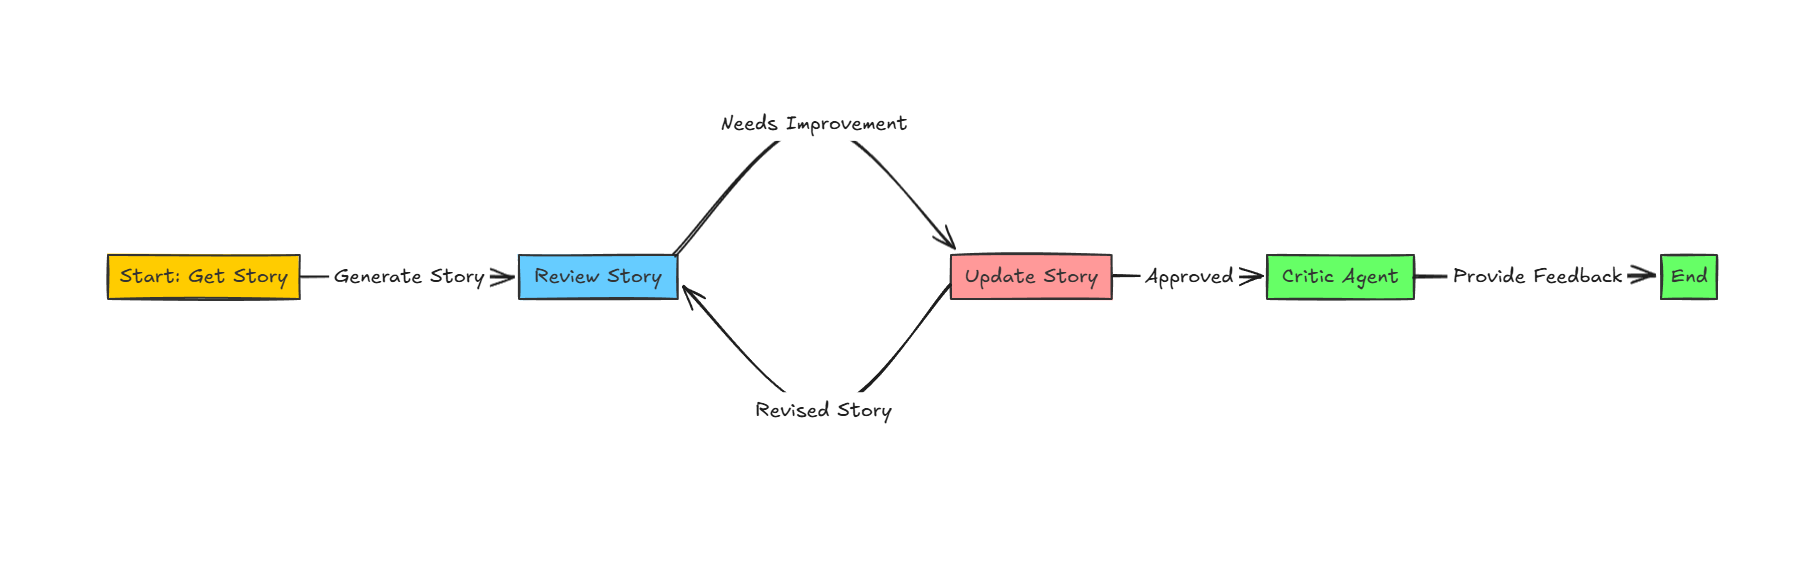

#### 6.7 Agents
<style>
  img {
    width: 700px;
  }
</style>
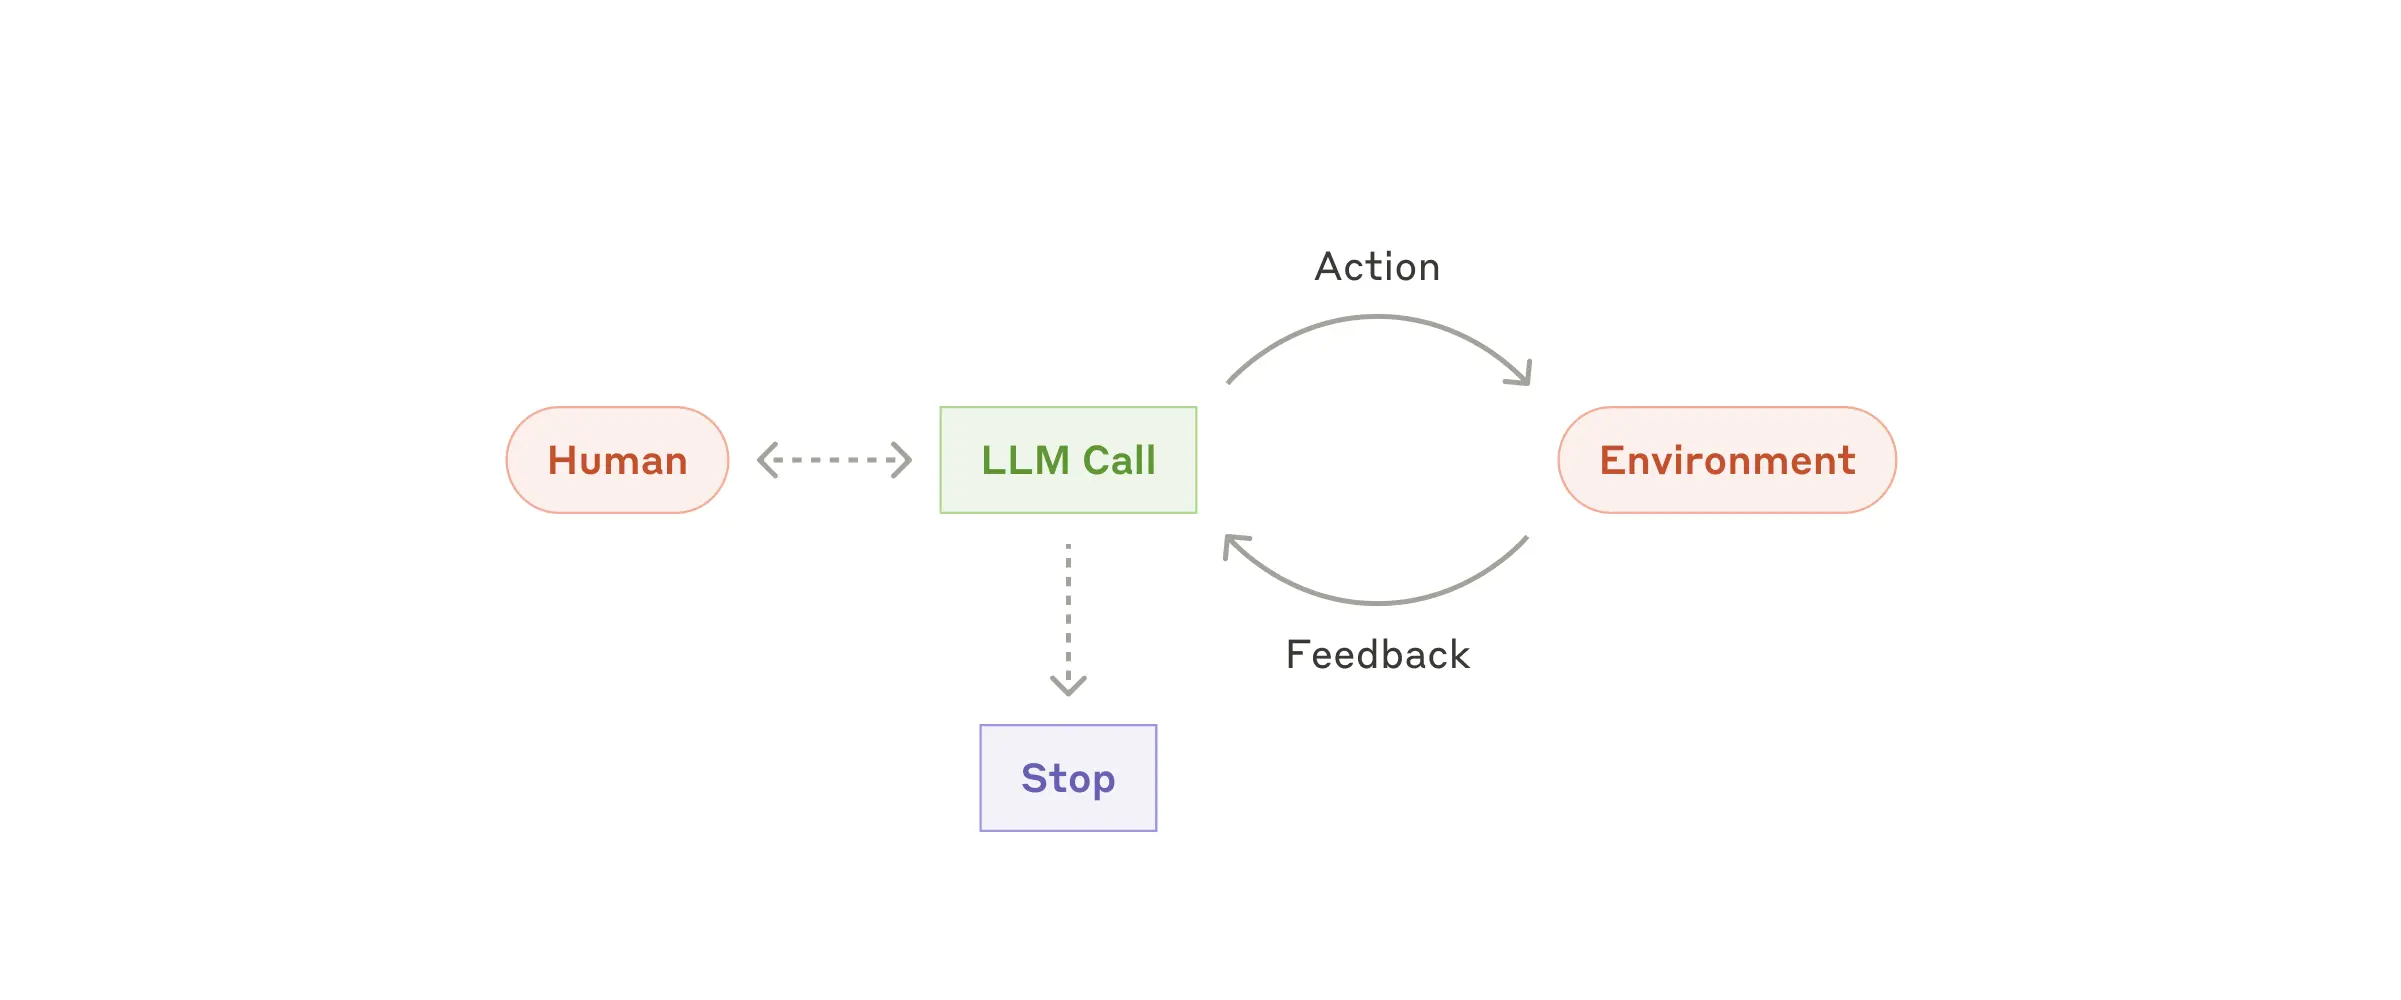

<style>
  img {
    width: 1200px;
  }
</style>
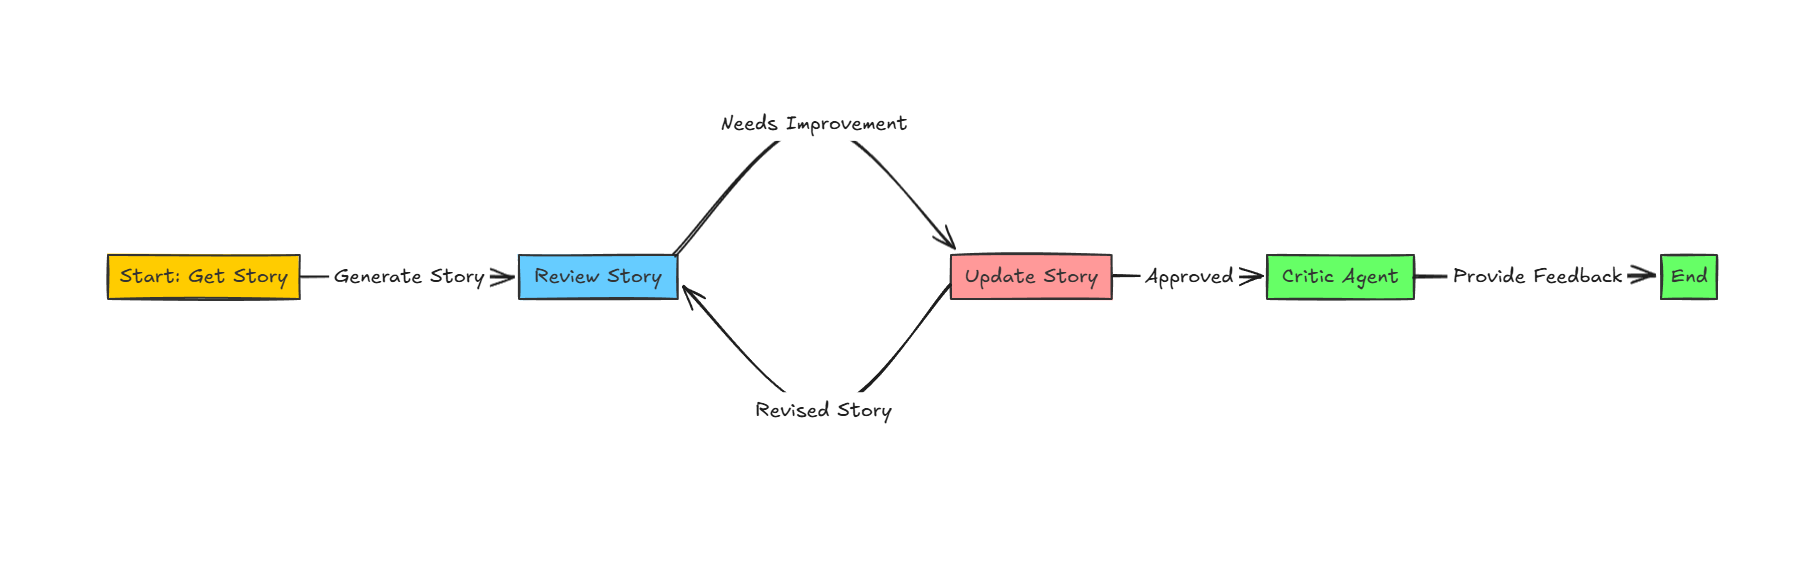

In [ ]:
import asyncio
from openai import OpenAI
from langgraph.graph import StateGraph,END
from pydantic import BaseModel
from typing import Optional

# ✅ Initialize OpenAI Client
# client = OpenAI() # Corrected: Using 'client' consistently

# ✅ Define State Model for LangGraph
class StoryState(BaseModel):
    story: str
    critic_comments: Optional[str] = None
    review_feedback: Optional[str] = None
    approved: bool = False  # ✅ Approval is given by the Reviewer

# ✅ 1️⃣ Story Agent (Writes Story)
def story_agent(state: StoryState) -> StoryState:
    print("📝 Story Agent: Generating a new sci-fi story...",)
    # print("The story is ",story)
    response = client_ollama.chat.completions.create( # Corrected: Using 'client' consistently
        model="qwen2.5:14b",
        messages=[{"role": "system", "content": "You are a helpful story writer assistant. Write a detailed and engaging sci-fi story based on the following topic:"}, # Improved system prompt
                  {"role": "user", "content": state.story}], # Corrected: Using state.story directly
    )
    story = response.choices[0].message.content
    # print(story)
    return StoryState(story=story, approved=False)

# ✅ 2️⃣ Critic Agent (Provides Story Quality Feedback)
def critic_agent(state: StoryState) -> StoryState:
    print("📝 Critic Agent: Analyzing the story for quality...")
    story = state.story
    response = client_ollama.chat.completions.create( # Corrected: Using 'client' consistently
        model="qwen2.5:14b",
        messages=[{"role": "system", "content": f"Provide a constructive and detailed critique on this sci-fi story, focusing on plot, character development, and overall engagement:\n{story}"}], # Improved system prompt
    )
    critic_comments = response.choices[0].message.content
    return StoryState(story=story, critic_comments=critic_comments, approved=state.approved)

# ✅ 3️⃣ Story Review Agent (Approves or Requests Changes)
def review_agent(state: StoryState) -> StoryState:
    print("📝 Story Review Agent: Reviewing the story and providing feedback...")
    story = state.story
    response = client_ollama.chat.completions.create( # Corrected: Using 'client' consistently
        model="qwen2.5:14b",
        messages=[
            {"role": "system", "content": f"Evaluate the following sci-fi story:\n{story}\n\n1. Provide specific and actionable feedback for improvement.\n2. If the story is well-written, engaging, and meets a high-quality standard, explicitly say 'approved'."} # Improved system prompt
        ],
    )
    review_feedback = response.choices[0].message.content

    # ✅ Check if the reviewer approved the story
    is_approved = "approved" in review_feedback.lower()

    return StoryState(story=story, critic_comments=state.critic_comments, review_feedback=review_feedback, approved=is_approved)

# ✅ 4️⃣ Update Story (Refines Story if Not Approved)
def update_story(state: StoryState) -> StoryState:
    if state.approved:
        print("✅ Story Approved by Reviewer!")
        return state  # ✅ Stop loop if approved
    else:
        print("🔄 Story needs improvement. Updating story based on feedback...")
        new_story = f"{state.story}\n\n**Reviewer Feedback:** {state.review_feedback}\n\n**Revised Story:** [Revision based on feedback needed - currently just appending feedback, consider implementing actual revision logic here for a more advanced example]" # Enhanced update message
        return StoryState(story=new_story, approved=False) # In a real application, you would use feedback to actually rewrite/revise the story. This is a placeholder

# ✅ 5️⃣ Build the LangGraph Workflow
graph = StateGraph(StoryState)

# ✅ Add Nodes
graph.add_node("Get_story", story_agent)
graph.add_node("review", review_agent)
graph.add_node("update", update_story)
graph.add_node("critic", critic_agent)  # 🔹 Critic moved to the end

# ✅ Define Edges (Workflow Flow)
graph.add_edge("Get_story", "review")  # 🔹 Story goes to reviewer first
graph.add_edge("review", "update")  # 🔹 Reviewer decides if changes needed
graph.add_conditional_edges("update", lambda state: "review" if not state.approved else "critic")  # 🔹 Loop back if not approved
graph.add_edge("critic", END)  # 🔹 Ends after critic review

# ✅ Set Entry & Exit Points
graph.set_entry_point("Get_story")
# graph.set_finish_point("critic")  # ✅ Ends after critic feedback

# ✅ Compile the Graph
story_validation_graph = graph.compile()


# ✅ Convert to Mermaid format
from IPython.display import Image, display

display(Image(story_validation_graph.get_graph(xray=True).draw_mermaid_png()))


# ✅ Run the LangGraph Workflow
initial_state = StoryState(story= "AI and robots discovering the lost city of Atlantis.") # More specific story prompt
print("Initial State:", initial_state)

result = story_validation_graph.invoke(initial_state) # ✅ Executing the LangGraph
print("\nFinal Result:", result)

In [ ]:
# Helper function
import textwrap
from IPython.display import Markdown
def to_markdown(text):
    # text = text.replace('*',' *')
    return Markdown(textwrap.indent(text,'> ',predicate=lambda _:True))

to_markdown(result['story'])